In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import time
import datetime as dt
import psutil
from PIL import Image
import matplotlib.pyplot as plt
from random import shuffle
import glob
import pickle
import torchvision
from torch.optim import lr_scheduler

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
def no_of_params(model):
    sum_ = 0
    for key, value in model.state_dict().items():
        sum_ += torch.prod(torch.tensor(value.shape))
        #print(value, "----------", torch.prod(torch.tensor(value.shape)))
    return int(sum_)

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        list_IDs,
    ):
        self.list_IDs  = list_IDs
        self.cache     = {}
        self.input_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_1/images/"
        self.label_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_1/labels"
        
    def __len__(self):
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        ID = self.list_IDs[index]
        if ID in self.cache:
            X = self.cache[ID]['X']
            Y = self.cache[ID]['Y']
        else:
            X = torchvision.io.read_image(
                self.input_dir + str(ID) + ".png "
            ).to(torch.float32)
            X = X[1].unsqueeze(0)/256.
            
            with open(self.label_dir + str(ID), 'rb') as fb:
                Y  = pickle.load(fb)
                
            #Y = [ (i + 3.)/6. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            #Y = [ i/3. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            
            Y = Y[1][0]/3.1415926
            Y = torch.tensor( Y, dtype=torch.float32 ).unsqueeze(0)
            
            if psutil.virtual_memory().percent < 50:
                data = {
                    'X' : X,
                    'Y' : Y
                }
                self.cache[ID] = data
        return X,Y

In [4]:
all_ids = [str(i) for i in  list(np.arange(0,1000,1))]
train_ids = all_ids[:800]
val_ids   = all_ids[800:]
params = {
    'batch_size'  : 32,
    'shuffle'     : True,
    #'num_workers' : 2
}
training_set         = Dataset(train_ids)
training_generator   = torch.utils.data.DataLoader(
                            training_set,
                            **params,
                            pin_memory=True
                        )
validation_set       = Dataset(val_ids)
validation_generator = torch.utils.data.DataLoader(
                            validation_set,
                            **params,
                            pin_memory=True
                        )

In [5]:
def train_one_epoch(
    model,
    optimizer
):
    running_loss = 0.
    loss_fn = nn.MSELoss()
    
    model.train()
    
    for i,batch in enumerate(training_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

def validate_one_epoch(
    model,
    optimizer
):
    running_loss = 0.
    loss_fn = nn.MSELoss()
    model.eval()
    
    for i,batch in enumerate(validation_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

In [6]:
class simple_cnn(nn.Module):
    def __init__(self):
        super(simple_cnn, self).__init__()
        self.conv1 = nn.Conv2d(1,4,kernel_size=4,padding=2,stride=2)
        self.conv2 = nn.Conv2d(4,8,kernel_size=4,padding=2,stride=2)
        self.conv3 = nn.Conv2d(8,16,kernel_size=4,padding=2,stride=2)
        self.conv4 = nn.Conv2d(16,32,kernel_size=4,padding=2,stride=2)
        #maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.activation = nn.Tanh()

        self.fc_1  = nn.Linear(9248,2048)
        self.fc_2  = nn.Linear(2048,1)
    
    def forward(self,x):
        
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.activation(x)
        x = self.conv4(x)
        x = self.activation(x)
        x = torch.flatten(x,1)
        x = self.fc_1(x)
        x = self.activation(x)
        x = self.fc_2(x)
        x = self.activation(x)
        
        return x

In [15]:
model = simple_cnn()
no_of_params(model)

18954877

In [16]:
lr = 1e-5
wd = 1e-2
epochs = 10
optimizer = torch.optim.Adam(
        model.parameters(),
        lr           = lr,
        weight_decay = wd
    )

gamma = 0.7
scheduler_step_size = 1
scheduler = lr_scheduler.StepLR(
    optimizer, 
    step_size = scheduler_step_size, 
    gamma     = gamma)

In [17]:
train_losses = []
val_losses   = []
for epoch in range(epochs):
    train_loss = train_one_epoch(model,optimizer)
    val_loss   = validate_one_epoch(model,optimizer)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    scheduler.step()
    print("EPOCH: ",epoch + 1, " Train loss: ", train_loss, " Val loss: ",val_loss)

EPOCH:  1  Train loss:  0.1857634189724922  Val loss:  0.27777242234774996
EPOCH:  2  Train loss:  0.29987546741962434  Val loss:  0.31591163149901796
EPOCH:  3  Train loss:  0.2744769471883774  Val loss:  0.21728404292038508
EPOCH:  4  Train loss:  0.11246378019452095  Val loss:  0.19278221683842794
EPOCH:  5  Train loss:  0.2814443862438202  Val loss:  0.10600564309528895
EPOCH:  6  Train loss:  0.08679452002048492  Val loss:  0.13686074955122812
EPOCH:  7  Train loss:  0.1701411285996437  Val loss:  0.19251725716250284
EPOCH:  8  Train loss:  0.2066578459739685  Val loss:  0.19916970069919313
EPOCH:  9  Train loss:  0.2175147783756256  Val loss:  0.22711543100220816
EPOCH:  10  Train loss:  0.21873999029397964  Val loss:  0.21356031937258585


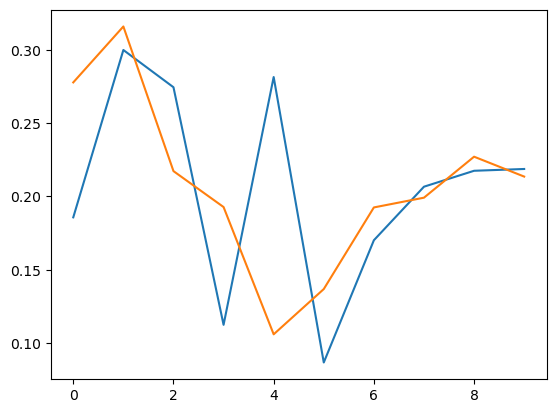

In [18]:
plt.plot(train_losses)
plt.plot(val_losses)

In [19]:
for batch in validation_generator:
    break

In [20]:
output = model(batch[0])
output

tensor([[0.8827],
        [0.8755],
        [0.8785],
        [0.8775],
        [0.8762],
        [0.8909],
        [0.8810],
        [0.8843],
        [0.8783],
        [0.8797],
        [0.8782],
        [0.8863],
        [0.8859],
        [0.8743],
        [0.8800],
        [0.8847],
        [0.8892],
        [0.8871],
        [0.8839],
        [0.8912],
        [0.8771],
        [0.8763],
        [0.8850],
        [0.8785],
        [0.8905],
        [0.8910],
        [0.8874],
        [0.8773],
        [0.8758],
        [0.8780],
        [0.8814],
        [0.8888]], grad_fn=<TanhBackward0>)

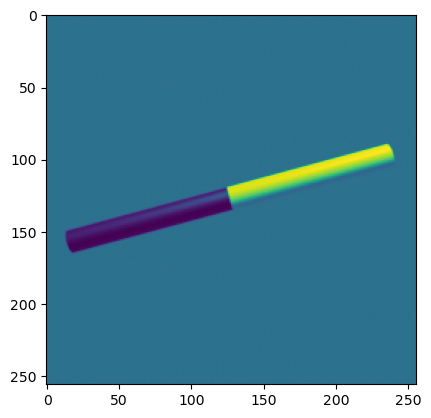

In [23]:
plt.imshow(batch[0][0][0])